# Implementing Loopy Belief Propagation in Python

The most parts were done by Jessical Stringham in her Notebook [here](https://jessicastringham.net/2019/01/09/sum-product-message-passing). I adapted it only a little to experiment with loopy belief propagation. Most credits are hers! I am really thankful that she has provided such a comprehensive explanation.

## Belief Propagation

I'll give (copy) here Jessica Stringham's introduction into this topic and focus then on the algorithm that can perform inference on factor graphs that may have cycles.

[Belief propagation](https://en.wikipedia.org/wiki/Belief_propagation) (or sum-product message passing) is a method that can do inference on [probabilistic graphical models](https://en.wikipedia.org/wiki/Graphical_model). It is applying the sum rules and product rules of probability to compute different distributions. For example, if a discrete probability distribution $p(h_1, v_1, h_2, v_2)$ can be factorized as

$$p(h_1, h_2, v_1, v_2) = p(h_1)p(h_2 \mid h_1)p(v_1 \mid h_1)p(v_2 \mid h_2),$$

To compute the marginals, for example, $p(v_1)$, we have to multiply the terms and summing over the other variables.

$$p(v_1) =  \sum_{h_1, h_2, v_2} p(h_1)p(h_2 \mid h_1)p(v_1 \mid h_1)p(v_2 \mid h_2),$$

With marginals, one can compute distributions such as $p(v_1)$ and $p(v_1, v_2)$, which means that one can also compute terms like $p(v_2 \mid v_1)$. Belief propagation provides an efficient method for computing these marginals. 

This version will only work on discrete distributions.

In [23]:
import numpy as np
from collections import namedtuple

## Representing probability distributions as numpy arrays

The sum-product message passing involves representing, summing, and multiplying discrete distributions. 

A discrete conditional distribution $p(v_1 \mid h_1)$ can be represented as an array with two axes, such as

| | $h_1$ = a | $h_1$ = b | $h_1$ = c |
|-|-|-|-|
| $v_1$ = 0 | 0.4 | 0.8 | 0.9 |
| $v_1$ = 1 | 0.6 | 0.2 | 0.1 |


Using an axis for each variable can generalize to more variables. For example, the 5-variable $p(h_5 \mid h_4, h_3, h_2, h_1)$ could be represented by an array with five axes. 

It's useful to label axes with variable names using `namedtuple`! (It's kind of like a janky version of the [NamedTensor](http://nlp.seas.harvard.edu/NamedTensor).)

In [24]:
LabeledArray = namedtuple('LabeledArray', [
    'array',
    'axes_labels',
])

def name_to_axis_mapping(labeled_array):
    return {
        name: axis
        for axis, name in enumerate(labeled_array.axes_labels)
    }

def other_axes_from_labeled_axes(labeled_array, axis_label):
    # returns the indexes of the axes that are not axis label
    return tuple(
        axis
        for axis, name in enumerate(labeled_array.axes_labels)
        if name != axis_label
    )

### Checking that a numpy array is a valid discrete distribution

It's easy to accidentally swap axes when creating numpy arrays representing distributions. 

To check that a multidimensional array is a _joint_ distribution, the entire array should sum to one.

To check that a 2D array is a _conditional_ distribution, when all of the right-hand-side variables have been assigned, such as $p(v_1 \mid h_1 = a)$, the resulting vector represents a distribution. The vector should have the length of the number of states of $v_1$ and should sum to one. Computing this in numpy involves summing along the axis corresponding to the $v_1$ variable.

To generalize conditional distribution arrays to the multi-dimensional example, again, when all of the right-hand-side variables have been assigned, such as $p(h_5 \mid h_4=a, h_3=b, h_2=a, h_1=a)$, the resulting vector represents a distribution. The vector should have a length which is the number of states of $h_5$ and should sum to one.

In [25]:
def is_conditional_prob(labeled_array, var_name):
    '''
    labeled_array (LabeledArray)
    variable (str): name of variable, i.e. 'a' in p(a|b)
    '''
    return np.all(np.isclose(np.sum(
        labeled_array.array,
        axis=name_to_axis_mapping(labeled_array)[var_name]
    ), 1.0))
    
def is_joint_prob(labeled_array):
    return np.all(np.isclose(np.sum(labeled_array.array), 1.0))

In [26]:
p_v1_given_h1 = LabeledArray(np.array([[0.4, 0.8, 0.9], [0.6, 0.2, 0.1]]), ['v1', 'h1'])

p_h1 = LabeledArray(np.array([0.6, 0.3, 0.1]), ['h1'])

p_v1_given_many = LabeledArray(np.array(
    [[[0.9, 0.2, 0.4], [0.3, 0.2, 0.9]],
     [[0.1, 0.8, 0.6], [0.7, 0.8, 0.1]]]
), ['v1', 'h1', 'h2'])

assert is_conditional_prob(p_v1_given_h1, 'v1')
assert not is_joint_prob(p_v1_given_h1)

assert is_conditional_prob(p_h1, 'h1')
assert is_joint_prob(p_h1)

assert is_conditional_prob(p_v1_given_many, 'v1')
assert not is_joint_prob(p_v1_given_many)

### Multiplying distributions

In belief propagation we need to compute the product of distributions, such as $p(h_2 \mid h_1)p(h_1)$.

But only a multipication of a multidimensional array by a 1D array and occasionally a scalar is needed. 

For example

$$
p(h_2 \mid h_1) = \begin{pmatrix}
0.4 & 0.8 & 0.9 \\
0.6 & 0.2 & 0.1 \\
\end{pmatrix}
$$

$$
p(h_1) = \begin{pmatrix}
0.1 \\
0.3 \\
0.6 \\
\end{pmatrix}
$$

$$
p(h_2 \mid h_1)p(h_1) = \begin{pmatrix}
0.4 \cdot 0.1 & 0.8 \cdot 0.3 & 0.9 \cdot 0.6 \\
0.6 \cdot 0.1 & 0.2 \cdot 0.3 & 0.1 \cdot 0.6 \\
\end{pmatrix}
$$

This is implemented by aliging the axis of the 1D array with its corresponding axis from the other distribution. Then the 1D array is tiled to be the size of $p(h_2 \mid h_1)$. This gives the joint distribution $p(h_1, h_2)$.

In [27]:
def tile_to_shape_along_axis(arr, target_shape, target_axis):
    # get a list of all axes
    raw_axes = list(range(len(target_shape)))
    tile_dimensions = [target_shape[a] for a in raw_axes if a != target_axis]
    if len(arr.shape) == 0:
        # If given a scalar, also tile it in the target dimension (so it's a bunch of 1s)
        tile_dimensions += [target_shape[target_axis]]
    elif len(arr.shape) == 1:
        # If given an array, it should be the same shape as the target axis
        assert arr.shape[0] == target_shape[target_axis]
        tile_dimensions += [1]
    else:
        raise NotImplementedError()
    tiled = np.tile(arr, tile_dimensions)

    # Tiling only adds prefix axes, so rotate this one back into place
    shifted_axes = raw_axes[:target_axis] + [raw_axes[-1]] + raw_axes[target_axis:-1]
    transposed = np.transpose(tiled, shifted_axes)

    # Double-check this code tiled it to the correct shape
    assert transposed.shape == target_shape
    return transposed

def tile_to_other_dist_along_axis_name(tiling_labeled_array, target_array):
    assert len(tiling_labeled_array.axes_labels) == 1
    target_axis_label = tiling_labeled_array.axes_labels[0]
    
    return LabeledArray(
        tile_to_shape_along_axis(
            tiling_labeled_array.array,
            target_array.array.shape,
            name_to_axis_mapping(target_array)[target_axis_label]
        ),
        axes_labels=target_array.axes_labels
    )

In [28]:
tiled_p_h1 = tile_to_other_dist_along_axis_name(p_h1, p_v1_given_h1)

# Check that the product is a joint distribution (p(v1, h1))
assert np.isclose(np.sum(p_v1_given_h1.array * tiled_p_h1.array), 1.0)

## Factor Graphs

Factor graphs are used to represent a distribution for sum-product message passing.
One factor graph that represents $p(h_1, h_2, v_1, v_2)$ is

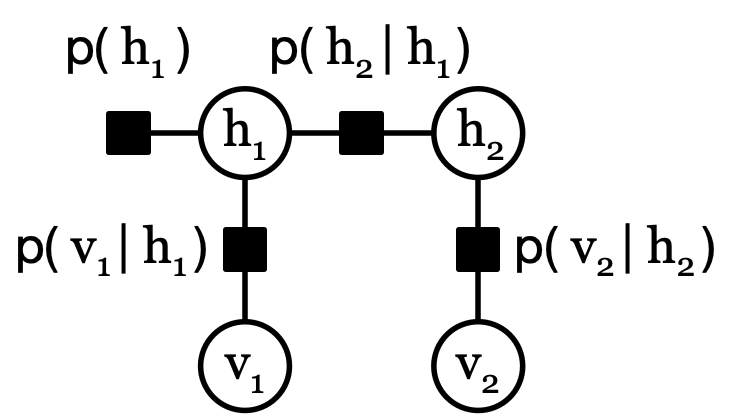

Factors, such as $p(h_1)$, are represented by black squares and represent a factor (or function, such as a probability distribution.) Variables, such as $h_1$, are represented by white circles. Variables only neighbor factors, and factors only neighbor variables.

In code, 
 - There are two classes in the graph: Variable and Factor. Both classes have a string representing the name and a list of neighbors.
 - A Variable can only have Factors in its list of neighbors. A Factor can only have Variables.
 - To represent the probability distribution, Factors also have a field for data.
 - A source of message passing's efficiency is that messages from one computation can be reused by other computations. Thus we store the message that was last past between Factor and Variable in an edge. We need this to later for the Loopy Belief Propagation algorithm. (this here is a little different from Jessica Stringham's version)

In [110]:
class Edge(object):
    def __init__(self, neighbor):
        self.message = None;
        self.neighbor = neighbor;

    def __repr__(self):
        return "{classname}\nMessage:\n{message}\nNeighbor:\n{neighbor}".format(
            classname=type(self).__name__,
            message=self.message,
            neighbor=self.neighbor
        )

class Node(object):
    def __init__(self, name):
        self.name = name
        self.edges = []

    def __repr__(self):
        return "{classname}({name}, [{edges}])".format(
            classname=type(self).__name__,
            name=self.name,
            edges=', '.join([e.neighbor.name for e in self.edges])
        )

    def is_valid_neighbor(self, neighbor):
        raise NotImplemented()

    def add_neighbor(self, neighbor):
        raise NotImplemented()

    def init_messages(self, value):
        for edge in self.edges:
            edge.message = value;

class Variable(Node):
    def is_valid_neighbor(self, factor):
        return isinstance(factor, Factor)  # Variables can only neighbor Factors

    def add_neighbor(self, neighbor):
        assert self.is_valid_neighbor(neighbor)
        self.edges.append(Edge(neighbor))
        neighbor.add_neighbor(self) 

class Factor(Node):
    def is_valid_neighbor(self, variable):
        return isinstance(variable, Variable)  # Factors can only neighbor Variables

    def __init__(self, name, data):
        super(Factor, self).__init__(name)
        self.data = data

    def add_neighbor(self, neighbor):
        assert self.is_valid_neighbor(neighbor)
        self.edges.append(Edge(neighbor));



## Parsing distributions into graphs

There is a nice little parser in Jessica Stringham's notebook to parse a string like `p(h1)p(h2∣h1)p(v1∣h1)p(v2∣h2)` as a factor graph. I don't want to use this here and define the factor graph later directly in code.

## Adding distributions to the graph

Before we can run the algorithm, we need to associate LabeledArrays with each Factor. 

In [111]:
h1 = Variable('h1');
h2 = Variable('h2');
v1 = Variable('v1');
v2 = Variable('v2');

p_h1 = Factor('p(h1)', LabeledArray(np.array([[0.2], [0.8]]), ['h1']))
p_h2_given_h1 = Factor('p(h2|h1)', LabeledArray(np.array([[0.5, 0.2], [0.5, 0.8]]), ['h2', 'h1']))
p_v1_given_h1 = Factor('p(v1|h1)', LabeledArray(np.array([[0.6, 0.1], [0.4, 0.9]]), ['v1', 'h1']))
p_v2_given_h2 = Factor('p(v2|h1)', LabeledArray(p_v1_given_h1.data.array, ['v2', 'h2']))

assert is_joint_prob(p_h1.data)
assert is_conditional_prob(p_h2_given_h1.data, 'h2')
assert is_conditional_prob(p_v1_given_h1.data, 'v1')
assert is_conditional_prob(p_v2_given_h2.data, 'v2')

h1.add_neighbor(p_h1)
h1.add_neighbor(p_h2_given_h1)
h1.add_neighbor(p_v1_given_h1)

h2.add_neighbor(p_h2_given_h1)
h2.add_neighbor(p_v2_given_h2)

v1.add_neighbor(p_v1_given_h1)
v2.add_neighbor(p_v2_given_h2)

belief_network = [h1, h2, v1, v2, p_h1, p_h2_given_h1, p_v1_given_h1, p_v2_given_h2]

## Belief Propagation

Now we can implement sum-product message passing. 

Sum-product message passing will compute values ("messages") for every edge in the factor graph.

The algorithm will compute a message from the Factor $f$ to the Variable $x$, notated as $\mu_{f \to x}(x)$. It will also compute the value from Variable $x$ to the Factor $f$, $\mu_{x \to f}(x)$. As is common in graph algorithms, these are defined recursively.

(I'm using the equations as given in Barber p84.)

### Variable-to-Factor Message

The variable-to-factor message is given by:

$$\mu_{x \to f}(x) = \prod_{g \in \{ne(x) \setminus f\}} \mu_{g \to x}(x)$$

where $ne(x)$ are the neighbors of $x$.

### Factor-to-Variable Message

The variable-to-factor message is given by 

$$\mu_{f \to x}(x) = \sum_{\chi_f \setminus x}\phi_f(\chi_f) \prod_{y \in \{ne(f) \setminus x \}} \mu_{y \to f}(y)$$

In the case of probabilities, $\phi_f(\chi_f)$ is the probability distribution associated with the factor, and $\sum_{\chi_f \setminus x}$ sums over all variables except $x$.


### Marginal

The marginal of a variable $x$ is given by

$$p(x) \propto \prod_{f \in ne(x)}\mu_{f \to x}(x)$$

# Implementation of Belief Propagation for Trees without Cycles

In [85]:
class BeliefPropagation(object):
    def _variable_to_factor_messages(self, variable, factor):
        # Take the product over all incoming factors into this variable except the variable
        incoming_messages = [
            self.factor_to_variable_message(edge_to_factor, variable)
            for edge_to_factor in variable.edges
            if edge_to_factor.neighbor.name != factor.name
        ]

        # If there are no incoming messages, this is 1
        return np.prod(incoming_messages, axis=0)
    
    def _factor_to_variable_messages(self, factor, variable):
        # Compute the product
        factor_dist = np.copy(factor.data.array)
        for edge_to_variable in factor.edges:
            if edge_to_variable.neighbor.name == variable.name:
                continue
            incoming_message = self.variable_to_factor_messages(edge_to_variable, factor)
            factor_dist *= tile_to_other_dist_along_axis_name(
                LabeledArray(incoming_message, [edge_to_variable.neighbor.name]),
                factor.data
            ).array
        # Sum over the axes that aren't `variable`
        other_axes = other_axes_from_labeled_axes(factor.data, variable.name)
        return np.squeeze(np.sum(factor_dist, axis=other_axes))
    
    def marginal(self, variable):
        # p(variable) is proportional to the product of incoming messages to variable.
        unnorm_p = np.prod([
            self.factor_to_variable_message(edge_to_factor, variable)
            for edge_to_factor in variable.edges
        ], axis=0)

        # At this point, we can normalize this distribution
        return unnorm_p/np.sum(unnorm_p)
    
    def variable_to_factor_messages(self, edge_to_variable, factor):
        if edge_to_variable.message is None:
            edge_to_variable.message = self._variable_to_factor_messages(edge_to_variable.neighbor, factor)
        return edge_to_variable.message
        
    def factor_to_variable_message(self, edge_to_factor, variable):
        if edge_to_factor.message is None:
            edge_to_factor.message = self._factor_to_variable_messages(edge_to_factor.neighbor, variable)
        return edge_to_factor.message

In [86]:
BeliefPropagation().marginal(v2)

array([0.23, 0.77])

Right Value: array([0.23, 0.77])

In [87]:
BeliefPropagation().marginal(v1)

array([0.2, 0.8])

Right Value: array([0.2, 0.8])

# Iterative Loopy Belief Propagation

The message passing is done in the same way as defined above.

The variable-to-factor message is given by:

$$\mu_{x \to f}(x) = \prod_{g \in \{ne(x) \setminus f\}} \mu_{g \to x}(x)$$

where $ne(x)$ are the neighbors of $x$.

The variable-to-factor message is given by 

$$\mu_{f \to x}(x) = \sum_{\chi_f \setminus x}\phi_f(\chi_f) \prod_{y \in \{ne(f) \setminus x \}} \mu_{y \to f}(y)$$

These operations are executed for all variable nodes in parallel while fixing $\mu_{g \to x}(x)$ and updating the messages. The messages for the first iteration must be intialized with a prior.  It can be shown that this coverges for the most belief netwworks.

In [97]:
class LoopyBeliefPropagation(object):
    def loop(self, n_iterations, belief_network):
        variables = [
            node
            for node in belief_network
            if isinstance(node, Variable) == True
        ]
        for i in range(n_iterations):
            for variable in variables:
                for edge_to_factor in variable.edges:
                    self.factor_to_variable_message(edge_to_factor, variable)

    def _variable_to_factor_messages(self, variable, factor):
        # Take the product over all incoming factors into this variable except the variable
        incoming_messages = [
            # self.factor_to_variable_message(edge_to_factor, variable)
            # use instead the fixed point
            edge_to_factor.message
            for edge_to_factor in variable.edges
            if edge_to_factor.neighbor.name != factor.name
        ]

        # If there are no incoming messages, this is 1
        return np.prod(incoming_messages, axis=0)
    
    def _factor_to_variable_messages(self, factor, variable):
        # Compute the product
        factor_dist = np.copy(factor.data.array)
        for edge_to_variable in factor.edges:
            if edge_to_variable.neighbor.name == variable.name:
                continue
            incoming_message = self.variable_to_factor_messages(edge_to_variable, factor)
            factor_dist *= tile_to_other_dist_along_axis_name(
                LabeledArray(incoming_message, [edge_to_variable.neighbor.name]),
                factor.data
            ).array
        # Sum over the axes that aren't `variable`
        other_axes = other_axes_from_labeled_axes(factor.data, variable.name)
        return np.squeeze(np.sum(factor_dist, axis=other_axes))
    
    def marginal(self, variable):
        # p(variable) is proportional to the product of incoming messages to variable.
        unnorm_p = np.prod([
            #self.factor_to_variable_message(edge_to_factor, variable)
            edge_to_factor.message
            for edge_to_factor in variable.edges
        ], axis=0)

        # At this point, we can normalize this distribution
        return unnorm_p/np.sum(unnorm_p)
    
    def variable_to_factor_messages(self, edge_to_variable, factor):
        edge_to_variable.message = self._variable_to_factor_messages(edge_to_variable.neighbor, factor)
        return edge_to_variable.message
        
    def factor_to_variable_message(self, edge_to_factor, variable):
        edge_to_factor.message = self._factor_to_variable_messages(edge_to_factor.neighbor, variable)
        return edge_to_factor.message

## Test Loopy Belief Propagation with One Iteration

In [118]:
for node in belief_network:
  node.init_messages([100000, 1]); # initialze with a strange prior

LoopyBeliefPropagation().loop(1, belief_network);

print(LoopyBeliefPropagation().marginal(v1))
print(LoopyBeliefPropagation().marginal(v2))



[0.29230414 0.70769586]
[0.23 0.77]


Correct Values: 
```
array([0.2, 0.8])
array([0.23, 0.77])
```



## Test Loopy Belief Propagation with Two Iterations 

coverges already.

In [119]:
for node in belief_network:
  node.init_messages([100000, 1]); # initialze with a strange prior

LoopyBeliefPropagation().loop(2, belief_network);

print(LoopyBeliefPropagation().marginal(v1))
print(LoopyBeliefPropagation().marginal(v2))



[0.2 0.8]
[0.23 0.77]


## See Also
 - Python library [pgmpy](https://github.com/pgmpy/pgmpy) does probabilistic graphical models and has nice code!